# Load Data

In [ ]:
! pip install pytorch_pretrained_bert
! pip install torchmetrics
! pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 KB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 KB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 6.8 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 33.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.insert(0, '/content/drive/MyDrive/Colab Notebooks/Capstone')
from utils import read_conll_file, read_data, filter_tag, create_sub_dir, read_unlabeled_data
from utils import TAG2IDX, IDX2TAG, DATA_DIR, POS_FINE_DIR, UNLABELED_DIR
from utils import MODEL_DIR, INT_RESULT_DIR, METRICS_DIR, RESULT_DIR, PLOT_TAGS_DIR
# from utils import wsj_train_word_lst, wsj_train_tag_lst, wsj_test_word_lst, wsj_test_tag_lst

from build_model import PosDataset, Net, DEVICE, TOKENIZER
from build_model import pad, train_one_epoch, eval

from analysis import save_sns_fig, analysis_output, make_plot_metric

from create_pseudo_data_by_tokens import gen_pseudo_data_for_token_by_unlabel

import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import pickle
from collections import Counter, defaultdict
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
from torch.utils import data
import torch.optim as optim
from pytorch_pretrained_bert import BertTokenizer, BertModel
from torchmetrics.functional.classification import multiclass_f1_score, multiclass_precision, multiclass_recall, multiclass_accuracy

torch.manual_seed(0)

import time


Mounted at /content/drive


100%|██████████| 213450/213450 [00:00<00:00, 320864.73B/s]


The number of samples: 30060
The number of tags 48
The number of samples: 1336
The number of tags 45
The number of samples: 1640
The number of tags 45


In [ ]:
def run_online_token_each_class(domain, token_top_percent, lr=0.000001, max_loop=10):

  print("=========================================================")
  print("Create directories")
  (sub_model_dir, sub_metrics_dir, sub_result_dir, 
    sub_int_res_dir) = create_sub_dir(domain, method_name="Online_token_self_learning_s2")

  print("=========================================================")
  print("Load data")
  time1 = time.time()

  ul_domain_file = os.path.join(UNLABELED_DIR, f"gweb-{domain}.unlabeled.txt")

  domain_dir = os.path.join(POS_FINE_DIR, f"{domain}")
  domain_dev_file = os.path.join(domain_dir, f"gweb-{domain}-dev.conll")
  domain_test_file = os.path.join(domain_dir, f"gweb-{domain}-test.conll")

  domain_dev_word_lst, domain_dev_tag_lst, domain_dev_tag_set = read_data(domain_dev_file)
  domain_test_word_lst, domain_test_tag_lst, domain_test_tag_set = read_data(domain_test_file)

  domain_dev_word_lst, domain_dev_tag_lst = filter_tag(domain_dev_word_lst, domain_dev_tag_lst)  
  domain_test_word_lst, domain_test_tag_lst = filter_tag(domain_test_word_lst, domain_test_tag_lst)

  dev_dataset = PosDataset(domain_dev_word_lst, domain_dev_tag_lst)
  test_dataset = PosDataset(domain_test_word_lst, domain_test_tag_lst)

  dev_iter = data.DataLoader(
      dataset=dev_dataset,
      batch_size=8,
      shuffle=True,
      num_workers=1,
      collate_fn=pad)
  test_iter = data.DataLoader(
      dataset=test_dataset,
      batch_size=8,
      shuffle=False,
      num_workers=1,
      collate_fn=pad)

  time2 = time.time()
  print(" Running time:", time2 - time1)

  # =========================================================
  avg_domain_prec_lst = []
  avg_domain_rec_lst = []
  avg_domain_f1_lst = []
  avg_domain_acc_lst = []

  micro_domain_prec_lst = []
  micro_domain_rec_lst = []
  micro_domain_f1_lst = []
  micro_domain_acc_lst = []

  macro_domain_prec_lst = []
  macro_domain_rec_lst = []
  macro_domain_f1_lst = []
  macro_domain_acc_lst = []

  print("=========================================================")
  print("Start Self-training")

  loop_i = 0

  domain_unlabeled_data = read_unlabeled_data(ul_domain_file, max_unlabeled=100_000)

  time3 = time.time()
  print("  Running time:", time3 - time2)

  print("  The number of unlabeled data", len(domain_unlabeled_data))

  cnt_non_ignored_tokens = sum([len(s) for s in domain_unlabeled_data])
  token_topn = int(token_top_percent * cnt_non_ignored_tokens)
  print("  The number of non_ignored_tokens", cnt_non_ignored_tokens)
  print("  The number of token_topn", token_topn)

  while cnt_non_ignored_tokens >= token_topn and loop_i <= max_loop:
    
    time4 = time.time()

    loop_i += 1
    print("\nLoop", loop_i)

    # =========================================================
    # Load model
    if loop_i == 1:
      model_name = [name for name in os.listdir(MODEL_DIR) if "base_model_" in name][0]
      model_file = os.path.join(MODEL_DIR, model_name)
    else:
      model_name = [name for name in os.listdir(sub_model_dir) if f"model-top{token_top_percent}-loop{loop_i-1}-lr{lr}" in name][0]
      model_file = os.path.join(sub_model_dir, model_name)
    
    print(model_file)

    model = Net(vocab_size=len(TAG2IDX))
    model.to(DEVICE)
    model = nn.DataParallel(model)
    model.load_state_dict(torch.load(model_file))

    # =========================================================
    # Performance on test dataset

    output_res_file = os.path.join(sub_result_dir, f"top{token_top_percent}-loop{loop_i}-lr{lr}.txt")
    
    (test_prec_avg, test_rec_avg, test_f1_avg, acc_avg, 
      test_prec_micro, test_rec_micro, test_f1_micro, test_acc_micro, 
      test_prec_macro, test_rec_macro, test_f1_macro, test_acc_macro) = eval(
        model, test_iter, save_output=True, output_file=output_res_file)
    
    time5 = time.time()
    print(" Running time:", time5 - time4)

    avg_domain_prec_lst.append(test_prec_avg.item())
    avg_domain_rec_lst.append(test_rec_avg.item())
    avg_domain_f1_lst.append(test_f1_avg.item())
    avg_domain_acc_lst.append(acc_avg.item())

    micro_domain_prec_lst.append(test_prec_micro.item())
    micro_domain_rec_lst.append(test_rec_micro.item())
    micro_domain_f1_lst.append(test_f1_micro.item())
    micro_domain_acc_lst.append(test_acc_micro.item())

    macro_domain_prec_lst.append(test_prec_macro.item())
    macro_domain_rec_lst.append(test_rec_macro.item())
    macro_domain_f1_lst.append(test_f1_macro.item())
    macro_domain_acc_lst.append(test_acc_macro.item())

    csv_file_name = os.path.join(sub_result_dir, f"top{token_top_percent}-loop{loop_i}-lr{lr}.csv")
    output_plot_name = os.path.join(sub_result_dir, f"top{token_top_percent}-loop{loop_i}-lr{lr}.png")

    _ = analysis_output(
        output_res_file, csvsave=True, pngsave=True, 
        csv_file_name=csv_file_name, output_plot_name=output_plot_name, 
        figtitle=f"{domain}-top{token_top_percent}-loop{loop_i} Test: Accuracy for each tag")


    print("=========================================================")
    print("Generate new train dataset")

    print("  The number of unlabeled data", len(domain_unlabeled_data))

    if loop_i ==1:
      fake_tags = None

    ul_domain_dataset = PosDataset(domain_unlabeled_data, fake_tags)
    unlabel_iter = data.DataLoader(
        dataset=ul_domain_dataset,
        batch_size=8,
        shuffle=True,
        num_workers=1,
        collate_fn=pad
        )

    # Save analysis outputs for intermediate results
    output_int_res_file = os.path.join(sub_int_res_dir, f"top{token_top_percent}-loop{loop_i}-lr{lr}.txt")

    time6 = time.time()
    print(" Running time:", time6 - time5)

    (top_words, top_tags, top_pseudo_tags, top_prob_pseudo_tags, top_prob, 
    _, _, _, _, _)= gen_pseudo_data_for_token_by_unlabel(
          model, unlabel_iter, len(domain_unlabeled_data), save_output=True, output_file=output_int_res_file)
    
    print("  Total sentences", len(top_prob_pseudo_tags))
    assert len(top_words)==len(top_pseudo_tags)==len(top_prob_pseudo_tags)

    cnt_all_words = sum([len(s) for s in top_words])
    cnt_all_tags = sum([len(s) for s in top_tags])
    cnt_all_pseudo_tags = sum([len(s) for s in top_pseudo_tags])
    cnt_all_probs = sum([len(s) for s in top_prob_pseudo_tags])
    print("  Total tokens", cnt_all_probs)
    assert cnt_all_words==cnt_all_tags==cnt_all_pseudo_tags==cnt_all_probs

    time7 = time.time()
    print(" Running time:", time7 - time6)

    print("=========================================================")
    print("Select tokens by probability")
    
    non_ignored_tokens = []
    for tokens_i in top_tags:
      for token_i in tokens_i:
        if token_i != '<pad>':
          non_ignored_tokens.append(token_i)
    cnt_non_ignored_tokens = len(non_ignored_tokens)
    print("  Total non_ignored tokens", cnt_non_ignored_tokens)

    if cnt_non_ignored_tokens <= 100:
      print("  The number of non-ignored tokens is too few. Stop training")
      break
    
    print("  Select top tokens in each tag class")
    save_dict_path = os.path.join(sub_int_res_dir, f"top{token_top_percent}-loop{loop_i}-lr{lr}.pickle")
    each_tags_dict, thresholds_dict = select_topn_each_tag(
        top_tags, top_pseudo_tags, top_prob_pseudo_tags, cnt_non_ignored_tokens, token_topn,
        save=True, save_dict_path=save_dict_path)

    print("  Filter tags by probability")
    new_training_tags = []
    fake_tags = []
    for t, p in zip(top_pseudo_tags, top_prob_pseudo_tags):
      t_lst = []
      remain_t_lst = []
      for t_i, p_i in zip(t, p):

        if t_i not in thresholds_dict:
          t_lst.append('<pad>')
          remain_t_lst.append('<pad>')
        else:
          threshold_prob = thresholds_dict[t_i]

          if p_i >= threshold_prob:
            t_lst.append(t_i)
            remain_t_lst.append('<pad>')
          else:
            t_lst.append('<pad>')
            remain_t_lst.append(t_i)

      new_training_tags.append(t_lst)
      fake_tags.append(remain_t_lst)

    assert len(top_words)==len(new_training_tags)==len(fake_tags)

    time8 = time.time()
    print(" Running time:", time8 - time7)

    print("=========================================================")
    print("Generate new train dataset")

    domain_unlabeled_data = top_words
    new_train_dataset = PosDataset(domain_unlabeled_data, new_training_tags)
    new_train_iter = data.DataLoader(
        dataset=new_train_dataset,
        batch_size=8,
        shuffle=True,
        num_workers=1,
        collate_fn=pad)

    print("=========================================================")
    print("Self training for epochs")
    
    epoch_number = 0
    EPOCHS = 3

    best_vloss = 1_000_000.

    optimizer = optim.Adam(model.parameters(), lr = lr)
    loss_fn = nn.CrossEntropyLoss(ignore_index=0)

    for epoch in range(EPOCHS):
        print('  EPOCH {}:'.format(epoch_number + 1))

        model.train(True)
        avg_loss = train_one_epoch(model, new_train_iter, optimizer, loss_fn, epoch_number)

        model.train(False)

        running_vloss = 0.0
        for i, vbatch in enumerate(dev_iter):
          words, x, is_heads, tags, y, seqlens = vbatch

          logits, y, _ = model(x, y)
          logits = logits.view(-1, logits.shape[-1]) # (N*T, VOCAB)
          y = y.view(-1)  # (N*T,)
          
          vloss = loss_fn(logits, y)
          running_vloss += vloss

        avg_vloss = running_vloss / (i + 1)
        print('  LOSS train {} valid {}'.format(avg_loss, avg_vloss))

        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            model_path = os.path.join(sub_model_dir, f'model-top{token_top_percent}-loop{loop_i}-lr{lr}')
            torch.save(model.state_dict(), model_path)

        epoch_number += 1
    
  time9 = time.time()
  print(" Running time:", time9 - time8)

  print("=========================================================")
  print("Save metrics and probability list")

  metrics_df = pd.DataFrame({
      "avg_domain_prec_lst": avg_domain_prec_lst,
      "avg_domain_rec_lst": avg_domain_rec_lst,
      "avg_domain_f1_lst": avg_domain_f1_lst,
      "avg_domain_acc_lst": avg_domain_acc_lst,

      "micro_domain_prec_lst": micro_domain_prec_lst,
      "micro_domain_rec_lst": micro_domain_rec_lst,
      "micro_domain_f1_lst": micro_domain_f1_lst,
      "micro_domain_acc_lst": micro_domain_acc_lst,

      "macro_domain_prec_lst": macro_domain_prec_lst,
      "macro_domain_rec_lst": macro_domain_rec_lst,
      "macro_domain_f1_lst": macro_domain_f1_lst,
      "macro_domain_acc_lst": macro_domain_acc_lst

  })

  metrics_df.to_csv(os.path.join(sub_metrics_dir, f"metrics_df-top{token_top_percent}-lr{lr}.csv"), index=False)
  make_plot_metric(metrics_df, sub_metrics_dir, name=f"top{token_top_percent}-lr{lr}")

  time10 = time.time()
  print(" Running time:", time10 - time9)



In [ ]:
token_top_percent_lst = [0.01, 0.02] # 0.05, 0.1, 0.2
lr_lst = [0.00001, 0.000001]
DOMAIN_LST = ["answers", "emails", "newsgroups", "reviews", "weblogs"]


$$$ Run answers, token_top_percent 0.02, lr 1e-05
Already run

$$$ Run answers, token_top_percent 0.02, lr 1e-06
Create directories
Load data
The number of samples: 1745
The number of tags 49
The number of samples: 1744
The number of tags 50
after filter tag 1713
after filter tag 1723
 Running time: 2.4467461109161377
Start Self-training
Loaded... 27260 unlabeled instances
  Running time: 11.393845081329346
  The number of unlabeled data 27260
  The number of non_ignored_tokens 419790
  The number of token_topn 8395

Loop 1
/content/drive/MyDrive/Colab Notebooks/Capstone/model/base_model_20230105_184923_0


100%|██████████| 404400730/404400730 [00:32<00:00, 12320754.36B/s]


 Running time: 62.6002676486969
Generate new train dataset
  The number of unlabeled data 27260
 Running time: 2.522581100463867
  Total sentences 27260
  Total tokens 419790
 Running time: 107.60679054260254
Select tokens by probability
  Total non_ignored tokens 419790
  Select top tokens in each tag class
  Filter tags by probability
 Running time: 0.7802402973175049
Generate new train dataset
Self training for epochs
  EPOCH 1:
  batch 500 loss: nan
  batch 1000 loss: nan
  batch 1500 loss: nan
  batch 2000 loss: nan
  batch 2500 loss: nan
  batch 3000 loss: nan
  LOSS train nan valid 0.4140174090862274
  EPOCH 2:
  batch 500 loss: nan
  batch 1000 loss: nan
  batch 1500 loss: nan
  batch 2000 loss: nan
  batch 2500 loss: nan
  batch 3000 loss: nan
  LOSS train nan valid 0.4302563965320587
  EPOCH 3:
  batch 500 loss: nan
  batch 1000 loss: nan
  batch 1500 loss: nan
  batch 2000 loss: nan
  batch 2500 loss: nan
  batch 3000 loss: nan
  LOSS train nan valid 0.4585913121700287

Loop

KeyboardInterrupt: ignored

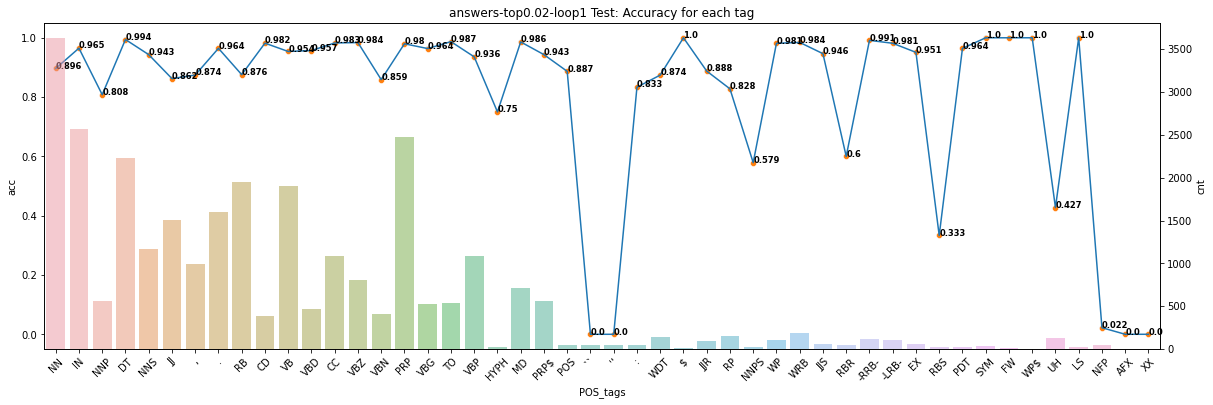

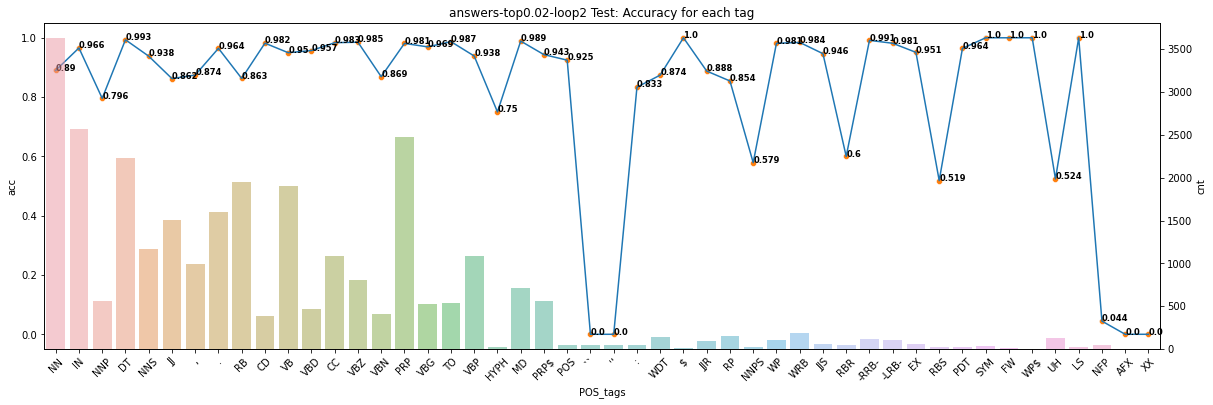

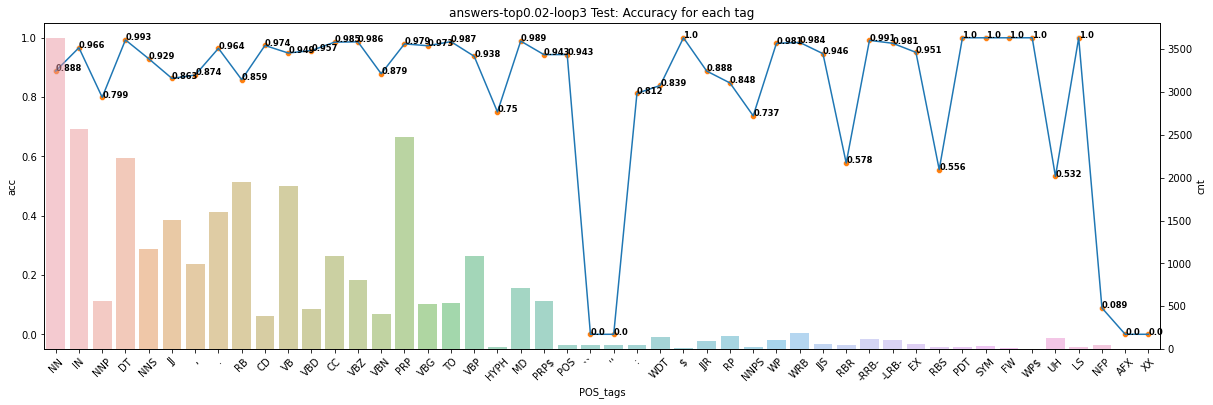

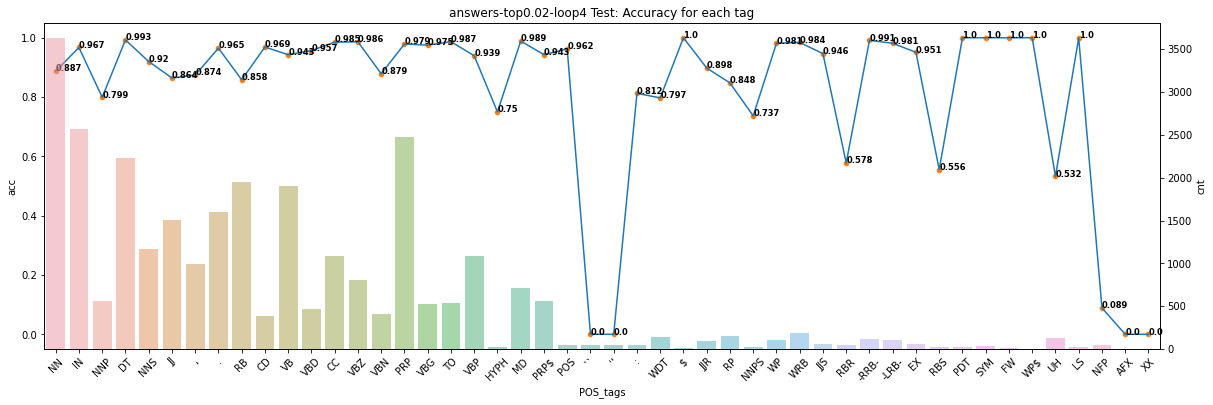

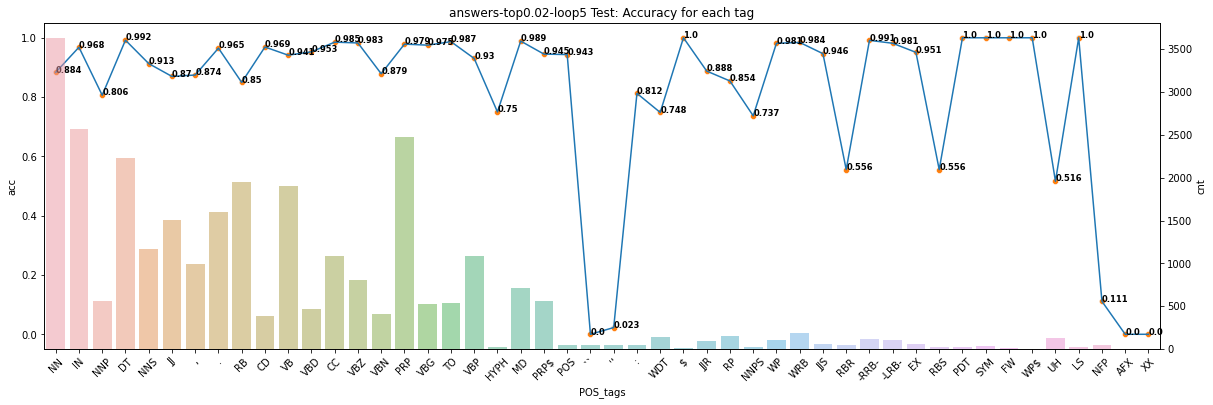

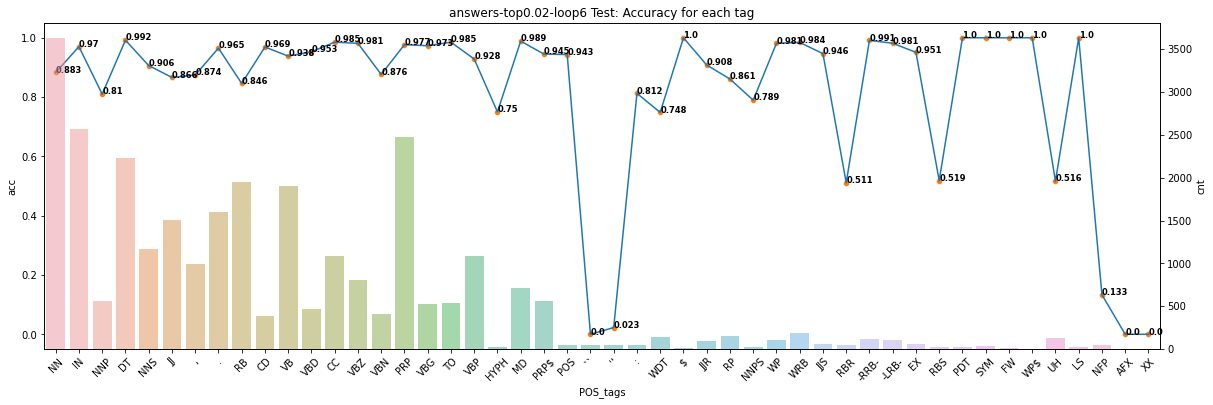

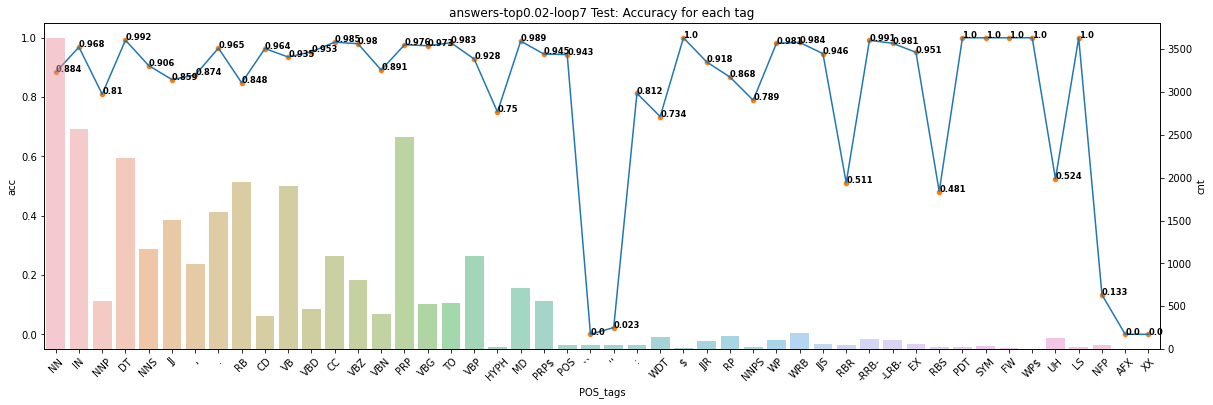

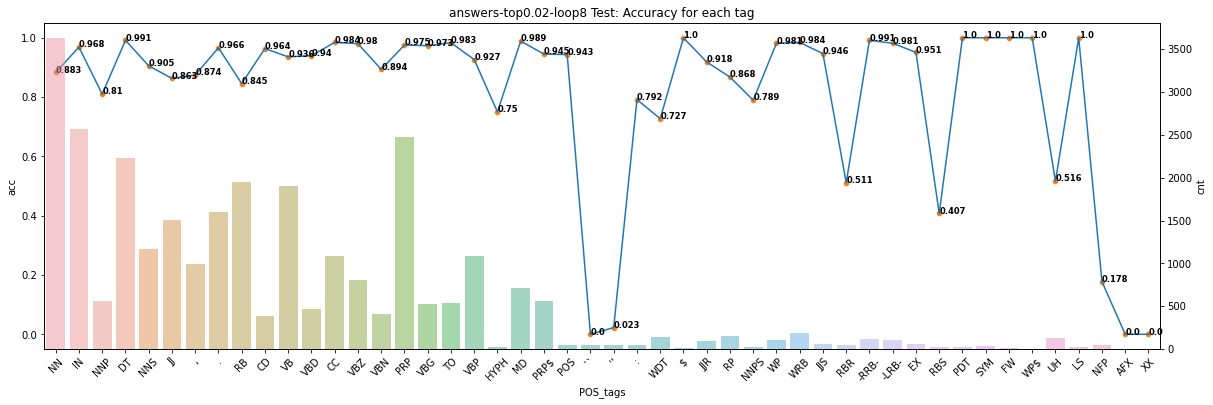

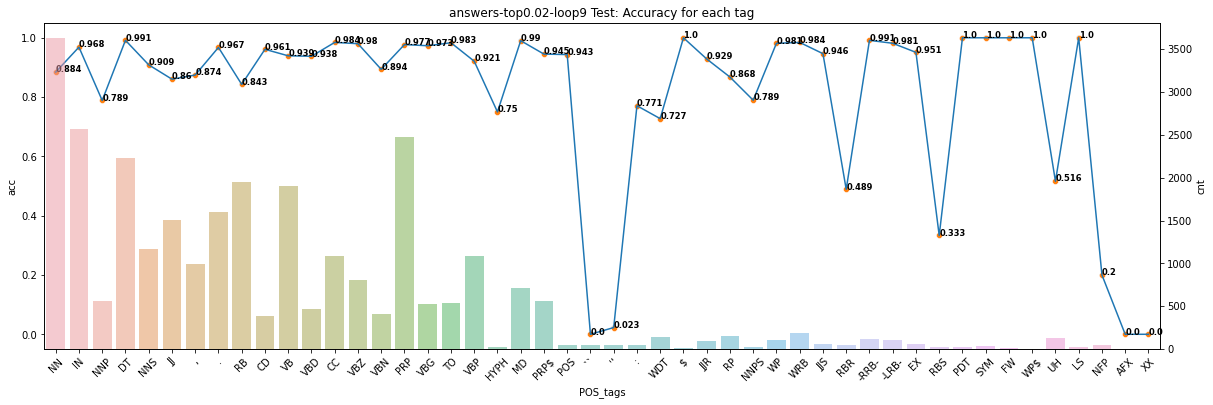

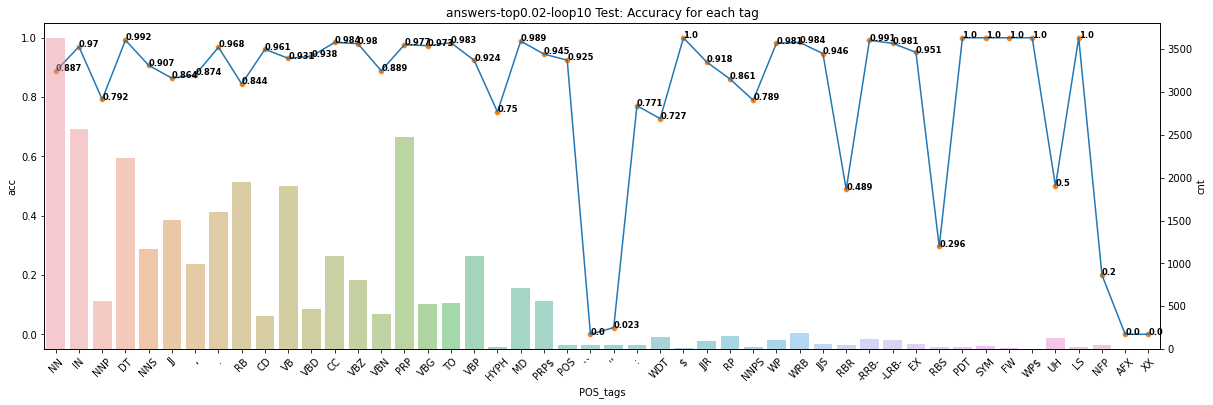

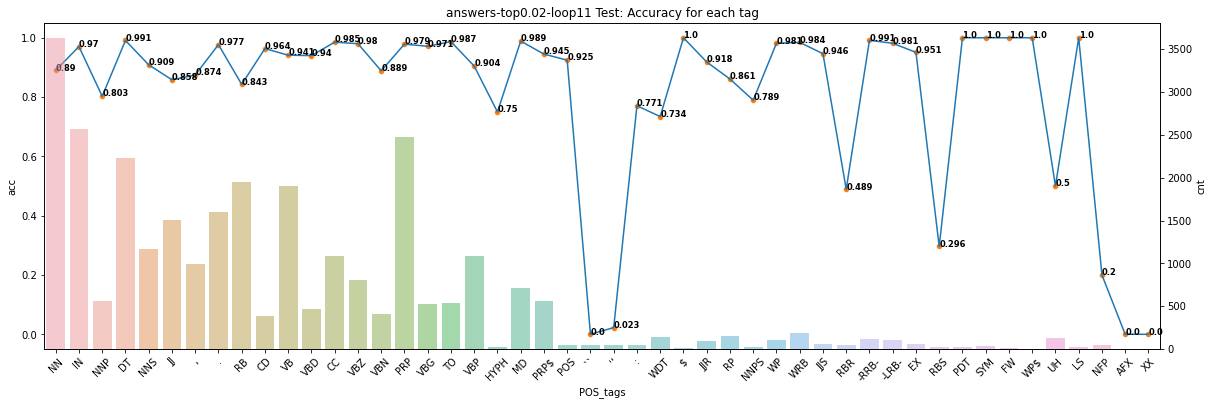

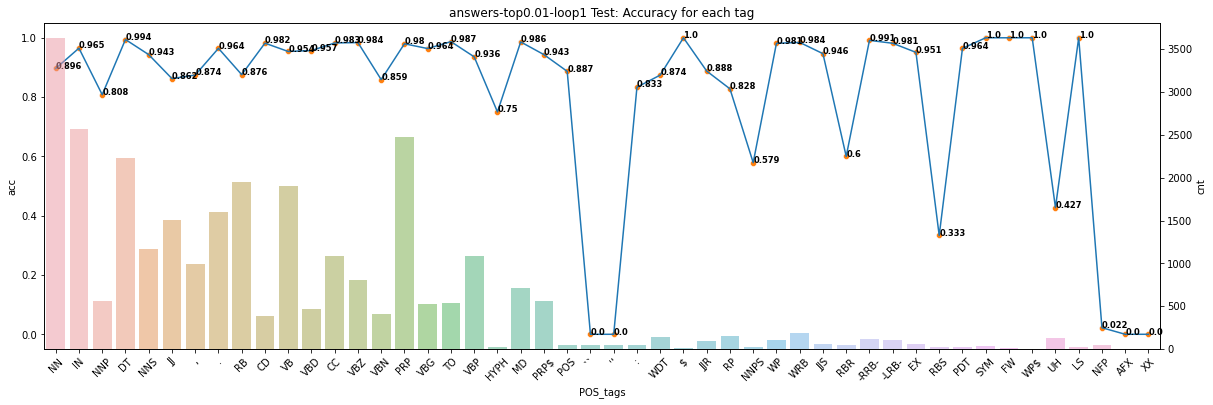

In [ ]:
for domain in DOMAIN_LST:
  for token_top_percent in token_top_percent_lst[::-1]:
    for lr in lr_lst:
      print(f"\n$$$ Run {domain}, token_top_percent {token_top_percent}, lr {lr}")
      # run_online_token_each_class(domain, top_percent, lr=lr)

      sub_metrics_dir = os.path.join(METRICS_DIR, "Online_token_self_learning_s2", domain)
      if os.path.exists(os.path.join(sub_metrics_dir, f"metrics_df-top{token_top_percent}-lr{lr}.csv")):
        print("Already run")
      else:
        run_online_token_each_class(domain, token_top_percent, lr=lr)
